Database initialized and CSV data imported successfully!

1. Manual HR Mode
2. AI-Powered HR Mode
3. Exit


Enter your choice:  2



--- EDA & Data Preprocessing ---

Missing Values:
ID                           0
Age                          0
Accessibility                0
EducationLevel               0
Gender                       0
WorkedBefore                 0
MentalHealth                 0
MainBranch                   0
YearsOfCoding                0
YearsOfCodingWhileWorking    0
Country                      0
PreviousSalary               0
HaveWorkedWith               0
ComputerSkills               0
Employed                     0
dtype: int64

Dropping duplicates...

EDA and Preprocessing complete.

--- Select Models to Train ---


Do you want to train Logistic Regression? (yes/no):  no
Do you want to train Decision Tree? (yes/no):  yes
Do you want to train Random Forest? (yes/no):  no



--- Training Decision Tree ---

Decision Tree Results:
Accuracy: 0.8992
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     18608
           1       0.90      0.89      0.90     18571

    accuracy                           0.90     37179
   macro avg       0.90      0.90      0.90     37179
weighted avg       0.90      0.90      0.90     37179



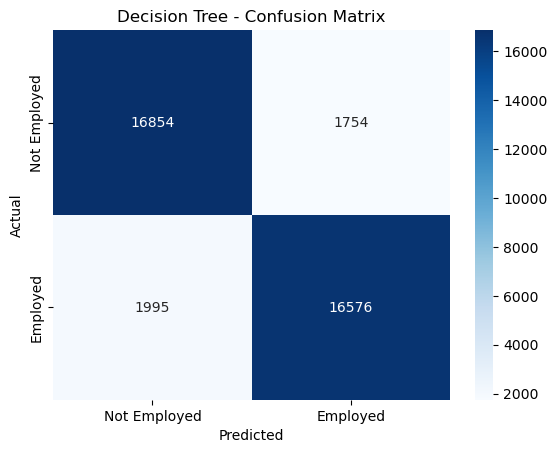

Decision Tree - AUC: 0.9768


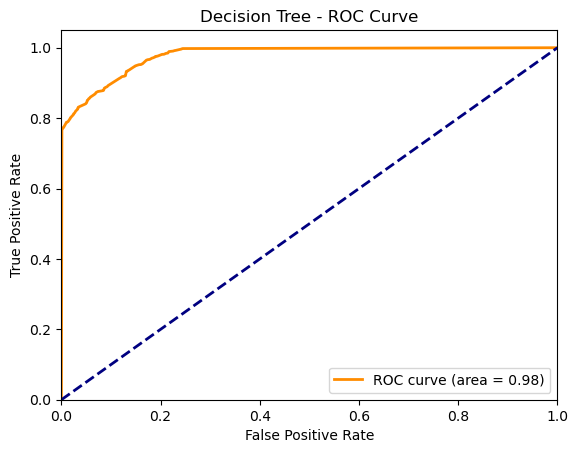


--- AI-Powered HR Mode ---
Available Trained Models:
1. Decision Tree


In [ ]:
import sqlite3
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving models

# Initialize database and load CSV
def initialize_database():
    con = sqlite3.connect('HR.db')
    cur = con.cursor()

    # Create table
    cur.execute("""
        CREATE TABLE IF NOT EXISTS EmployeesRecords (
            ID INTEGER PRIMARY KEY AUTOINCREMENT,
            Age INTEGER,
            Accessibility INTEGER,
            EducationLevel TEXT,
            Gender TEXT,
            WorkedBefore INTEGER,
            MentalHealth TEXT,
            MainBranch TEXT,
            YearsOfCoding INTEGER,
            YearsOfCodingWhileWorking INTEGER,
            Country TEXT,
            PreviousSalary REAL,
            HaveWorkedWith TEXT,
            ComputerSkills INTEGER,
            Employed INTEGER
        );
    """)

    # Import CSV
    with open("stackoverflow_full .csv", 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Skip the header row
        rows_to_insert = []
        for count, row in enumerate(reader):
            if count >= 50000:  # Limit to 50,000 rows
                break
            rows_to_insert.append(row[1:])  # Skip the first column (assuming it's an ID column)
        cur.executemany(f"""
            INSERT INTO EmployeesRecords (
                Age, Accessibility, EducationLevel, Gender, WorkedBefore, MentalHealth,
                MainBranch, YearsOfCoding, YearsOfCodingWhileWorking, Country, PreviousSalary,
                HaveWorkedWith, ComputerSkills, Employed
            )
            VALUES ({','.join(['?'] * (len(headers) - 1))});
        """, rows_to_insert)

    con.commit()
    con.close()
    print("Database initialized and CSV data imported successfully!")

# Retrieve Data from DB to DataFrame for EDA
def load_data_to_df():
    con = sqlite3.connect('HR.db')
    df = pd.read_sql_query("SELECT * FROM EmployeesRecords", con)
    con.close()
    return df

# Pretty-print DataFrame as a table
def print_pretty_table(df):
    print("\n" + tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

# EDA & Data Preprocessing
def perform_eda_and_preprocessing(df):
    print("\n--- EDA & Data Preprocessing ---")

    # Checking for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Dropping duplicate rows
    print("\nDropping duplicates...")
    df = df.drop_duplicates()

    # Encoding categorical variables
    label_encoder = LabelEncoder()
    categorical_columns = ['Age','Accessibility','EducationLevel', 'Gender', 'MentalHealth', 'MainBranch', 'Country']

    for col in categorical_columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))

    # Handle outliers (IQR method)
    def remove_outliers_iqr(data, column_name):
        Q1 = data[column_name].quantile(0.25)
        Q3 = data[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

    # Remove outliers
    for col in ['YearsOfCoding', 'PreviousSalary', 'ComputerSkills']:
        df = remove_outliers_iqr(df, col)

    # Feature and target selection
    X = df[['Age','Accessibility', 'ComputerSkills', 'PreviousSalary']]
    y = df['Employed']

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\nEDA and Preprocessing complete.")
    return X_train, X_test, y_train, y_test

# Train the selected model and print results
def train_model(model_name, X_train, X_test, y_train, y_test):
    print(f"\n--- Training {model_name} ---")

    if model_name == "Logistic Regression":
        model = LogisticRegression(random_state=0)
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state =42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
    else:
        print("Invalid model name.")
        return None

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'\n{model_name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(class_report)

    # Save the model
    joblib.dump(model, f"{model_name.replace(' ', '_')}.joblib")

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Employed', 'Employed'], yticklabels=['Not Employed', 'Employed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # Calculate the AUC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_score = auc(fpr, tpr)
    print(f'{model_name} - AUC: {auc_score:.4f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return model

# Train the models based on user selection
def train_models_and_get_models(X_train, X_test, y_train, y_test):
    print("\n--- Select Models to Train ---")
    models_to_train = []
    available_models = ["Logistic Regression", "Decision Tree", "Random Forest"]

    for model_name in available_models:
        choice = input(f"Do you want to train {model_name}? (yes/no): ").strip().lower()
        if choice == 'yes':
            models_to_train.append(model_name)

    trained_models = {}
    for model_name in models_to_train:
        trained_models[model_name] = train_model(model_name, X_train, X_test, y_train, y_test)

    return trained_models

# AI-Powered HR Mode: Model selection and prediction
def ai_hr_mode(models):
    print("\n--- AI-Powered HR Mode ---")
    while True:
        print("Available Trained Models:")
        for i, model_name in enumerate(models.keys(), start=1):
            print(f"{i}. {model_name}")
        choice = int(input("Select a model by number (or 0 to go back): "))
        if choice == 0:
            break
        model_name = list(models.keys())[choice - 1]
        model = models[model_name]
        print(f"Using {model_name} for predictions")

        # Get input for prediction
        age = int(input("Age: "))
        accessibility = int(input("Accessibility (1 or 0): "))
        computer_skills = int(input(" Number of Computer Skills: "))
        previous_salary = float(input("Previous Salary: "))

        # Predict
        prediction = model.predict([[age,accessibility, computer_skills, previous_salary]])[0]
        print(f"Prediction Result: {'Accepted' if prediction == 1 else 'Rejected'}")

        repeat = input("Do you want to make another prediction? (yes/no): ").strip().lower()
        if repeat != 'yes':
            break
            
# Manual HR Mode - Retrieve number of head rows
def retrieve_head_rows():
    con = sqlite3.connect('HR.db')
    df = pd.read_sql_query("SELECT * FROM EmployeesRecords", con)
    con.close()

    num_rows = int(input("Enter the number of rows you want to retrieve: "))
    print(f"\nFirst {num_rows} rows from the database:")
    print_pretty_table(df.head(num_rows))  # Pretty print the head rows

# Add Employee function
def add_employee():
    con = sqlite3.connect('HR.db')
    cur = con.cursor()

    # Input from user
    age = int(input("Enter Age: "))
    accessibility = int(input("Enter Accessibility (1 or 0): "))
    education_level = input("Enter Education Level: ")
    gender = input("Enter Gender: ")
    worked_before = int(input("Worked Before (1 or 0): "))
    mental_health = input("Enter Mental Health(Yes or No): ")
    main_branch = input("Enter Main Branch(Dev or NotDev: ")
    years_of_coding = int(input("Enter Years of Coding: "))
    years_of_coding_while_working = int(input("Enter Years of Coding While Working: "))
    country = input("Enter Country: ")
    previous_salary = float(input("Enter Previous Salary: "))
    have_worked_with = input("Enter Skills Have Worked With(comma seperated): ")
    computer_skills = int(input("Enter number of Computer Skills: "))
    employed = int(input("Employed (1 or 0): "))

    # Insert the new employee into the database
    cur.execute("""
        INSERT INTO EmployeesRecords (
            Age, Accessibility, EducationLevel, Gender, WorkedBefore, MentalHealth,
            MainBranch, YearsOfCoding, YearsOfCodingWhileWorking, Country, PreviousSalary,
            HaveWorkedWith, ComputerSkills, Employed
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (age, accessibility, education_level, gender, worked_before, mental_health, main_branch,
          years_of_coding, years_of_coding_while_working, country, previous_salary, have_worked_with,
          computer_skills, employed))

    con.commit()
    con.close()
    print("Employee added successfully!")

# Retrieve Employee function
def retrieve_employee():
    con = sqlite3.connect('HR.db')
    df = pd.read_sql_query("SELECT * FROM EmployeesRecords", con)
    con.close()

    emp_id = int(input("Enter Employee ID to retrieve: "))
    employee = df[df['ID'] == emp_id]
    print("\nEmployee Details:")
    print_pretty_table(employee)

# Delete Employee function
def delete_employee():
    con = sqlite3.connect('HR.db')
    cur = con.cursor()

    emp_id = int(input("Enter Employee ID to delete: "))
    cur.execute("DELETE FROM EmployeesRecords WHERE ID=?", (emp_id,))

    con.commit()
    con.close()
    print(f"Employee with ID {emp_id} deleted successfully!")

# Update Employee function
def update_employee():
    con = sqlite3.connect('HR.db')
    cur = con.cursor()

    emp_id = int(input("Enter Employee ID to update: "))

    # Get new data for updating
    age = int(input("Enter new Age: "))
    accessibility = int(input("Enter new Accessibility (1 or 0): "))
    education_level = input("Enter new Education Level: ")
    gender = input("Enter new Gender: ")
    worked_before = int(input("Worked Before (1 or 0): "))
    mental_health = input("Enter new Mental Health(Yes or No): ")
    main_branch = input("Enter new Main Branch(Dev or NotDev): ")
    years_of_coding = int(input("Enter new Years of Coding: "))
    years_of_coding_while_working = int(input("Enter new Years of Coding While Working: "))
    country = input("Enter new Country: ")
    previous_salary = float(input("Enter new Previous Salary: "))
    have_worked_with = input("Enter new Skills Have Worked With(comma seperated): ")
    computer_skills = int(input("Enter new number Computer Skills: "))
    employed = int(input("Employed (1 or 0): "))

    # Update the employee record in the database
    cur.execute("""
        UPDATE EmployeesRecords
        SET Age=?, Accessibility=?, EducationLevel=?, Gender=?, WorkedBefore=?, MentalHealth=?,
            MainBranch=?, YearsOfCoding=?, YearsOfCodingWhileWorking=?, Country=?, PreviousSalary=?,
            HaveWorkedWith=?, ComputerSkills=?, Employed=?
        WHERE ID=?
    """, (age, accessibility, education_level, gender, worked_before, mental_health, main_branch,
          years_of_coding, years_of_coding_while_working, country, previous_salary, have_worked_with,
          computer_skills, employed, emp_id))

    con.commit()
    con.close()
    print(f"Employee with ID {emp_id} updated successfully!")

# Manual HR Mode
def manual_hr_mode():
    while True:
        print("\nManual HR Mode")
        print("1. Add Employee")
        print("2. Retrieve Employee")
        print("3. Delete Employee")
        print("4. Update Employee")
        print("5. Retrieve Head Rows from DB")
        print("6. Go Back")

        choice = int(input("Enter your choice: "))

        if choice == 1:
            add_employee()
        elif choice == 2:
            retrieve_employee()
        elif choice == 3:
            delete_employee()
        elif choice == 4:
            update_employee()
        elif choice == 5:
            retrieve_head_rows()
        elif choice == 6:
            break
        else:
            print("Invalid choice. Please try again.")

# Main Menu
def main_menu():
    while True:
        print("\n1. Manual HR Mode")
        print("2. AI-Powered HR Mode")
        print("3. Exit")
        choice = int(input("Enter your choice: "))

        if choice == 1:
            manual_hr_mode()
        elif choice == 2:
            df = load_data_to_df()
            X_train, X_test, y_train, y_test = perform_eda_and_preprocessing(df)
            models = train_models_and_get_models(X_train, X_test, y_train, y_test)
            ai_hr_mode(models)
        elif choice == 3:
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    # Initialize database and load data
    initialize_database()
    # Main Menu
    main_menu()